# Topic 3: Linear Regression Analysis

## 1. Project Overview & Methodological Approach

This notebook represents the statistical modelling phase of my end-to-end Computational Social Science project investigating "Radicalisation Drift"- the potential migration of users from AI-Companion communities to Radical/Grievance subcultures (Incels/Femcels).

**The CSS Approach: Why this Dataset?**
Unlike standard machine learning exercises that often utilize pre-cleaned "toy datasets" (e.g., Titanic or Housing Prices), this project prioritizes **ecological validity**. I am working with a unique, self-collected dataset of ~10,000 posts and ~90,000 comments scraped directly from Reddit (see Notebook 1).

By applying rigorous statistical methods to organic, "in-the-wild" user data, this analysis aims to capture the messy, complex reality of online behavior. This approach allows us to move beyond simple prediction and focus on **inference**- understanding the underlying sociotechnical dynamics that drive emotional expression in digital communities.

## Research Objectives

In this specific notebook, we transition from the descriptive analysis of Notebook 2 (NLP) to **explanatory modelling**. We apply **Linear Regression** not merely to predict values, but to quantify the relationships between a user's environment and their emotional output.

**Specific Goals:**
1.  **Quantify Environmental Influence:** To measure exactly how much the "community context" (being in an Incel/Grievance group vs. an AI group) impacts the sentiment of a post, statistically isolating this effect from other factors.
2.  **Control for Confounders:** To ensure that any observed negativity is due to the community culture and not simply because radical posts are longer (`word_count`) or more controversial (`score`).
3.  **Statistical Rigor:** To validate these findings through essential diagnostic checks (multicollinearity, homoscedasticity, generalization error), proving that real-world social data can be modelled reliably.

## Research Question

> *To what extent does the community context (AI-Companion vs. Radical/Grievance) serve as a statistically significant predictor of a post's emotional sentiment, when controlling for user effort (word count), engagement (score), and content type?*

## Assessment Criteria Implementation

To satisfy the summative assessment requirements and ensure robust statistical inference, this notebook implements:
1.  **Multicollinearity Check:** Analysis of correlation matrices to ensure predictor independence and stable coefficients.
2.  **Model Comparison:** Fitting and comparing multiple model configurations (Baseline Univariate vs. Multivariate) to justify model complexity.
3.  **Residual Analysis:** Visual and statistical inspection of residuals to verify assumptions of homoscedasticity and random error distribution.
4.  **Generalisation Error:** Estimating the model's performance on unseen data with confidence intervals via K-Fold Cross-Validation.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rinm0\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
custom_data_path = "clean_final_reddit_data.csv"
custom_df = pd.read_csv(custom_data_path)

## 2. Feature Engineering & Data Preparation

Linear regression requires numerical inputs. In this step, we transform our unstructured text and categorical metadata into a structured feature matrix suitable for statistical modelling.

**Variables Constructed:**

1.  **Dependent Variable (Target $y$):**
    * **`sentiment`**: The VADER compound score (continuous range: -1.0 to +1.0). This quantifies the emotional tone of the content.

2.  **Independent Variables (Predictors $X$):**
    * **`is_grievance`** (Binary): The primary variable of interest. Mapped as `1` for Radical/Grievance communities and `0` for AI-Companion communities.
    * **`word_count`** (Continuous): A proxy for user effort. We control for this to ensure that negative sentiment isn't simply a function of longer "rants."
    * **`score`** (Continuous): A proxy for engagement/popularity.
    * **`is_post`** (Binary): Control variable distinguishing top-level submissions (`1`) from comments (`0`).

**Data Cleaning:**
* **Outlier Removal:** We filter out extremely long texts (> 500 words) to prevent outliers (e.g., fan-fiction or copy-pastas) from skewing the regression line.

### Methodological Refinement: Sentiment Calculation

**Note on Text Preprocessing:**
In the previous NLP notebook, I applied extensive cleaning (lemmatization, stopword removal) to optimize the data for Topic Modelling and Random Forest classification.

However, for this **Regression Analysis**, where accurate sentiment quantification is the primary target variable, I utilize **raw text**.
* **Reasoning:** VADER is designed to interpret "social media signals" such as capitalization (e.g., "SAD" vs "sad"), punctuation ("!"), and emoticons. Using raw text allows us to capture the **emotional intensity** of the posts, which was dampened by the standard NLP cleaning process in Notebook 2.

In [16]:
df = custom_df

# Feature engineering
print("Creating regression features...")

# A. Target Variable: Sentiment (Continuous)
df['sentiment'] = df['text'].fillna('').apply(lambda x: sid.polarity_scores(str(x))['compound'])

# B. Predictor 1: Community Type (Binary)
# 1 = Grievance (Radical), 0 = AI (Companion)
df_ml = df[df['subreddit_category'].isin(['ai', 'grievance'])].copy()
df_ml['is_grievance'] = df_ml['subreddit_category'].apply(lambda x: 1 if x == 'grievance' else 0)

# C. Predictor 2: Effort / Word Count (Continuous)
df_ml['word_count'] = df_ml['text'].fillna('').apply(lambda x: len(str(x).split()))

# D. Predictor 3: Popularity / Score (Continuous)
df_ml['score'] = df_ml['score'].fillna(0)

# E. Predictor 4: Content Type (Binary)
# 1 = Post, 0 = Comment
df_ml['is_post'] = df_ml['type'].apply(lambda x: 1 if x == 'post' else 0)

# Cleaning outliers for better regression 
df_ml = df_ml[df_ml['word_count'] < 500] # For longreads

print(f"Ready for Analysis. Samples: {len(df_ml)}")
display(df_ml[['sentiment', 'is_grievance', 'word_count', 'score', 'is_post']].head())

Creating regression features...
Ready for Analysis. Samples: 108442


,sentiment,is_grievance,word_count,score,is_post
0,0.9733,0,53,0,1
1,-0.1935,0,63,3,1
2,0.9184,0,38,18,1
3,0.9558,0,38,26,1
4,0.8534,0,72,33,1


## 3. Multicollinearity Check

Before training, we check for **multicollinearity** among predictors using a Correlation Matrix. High correlation between features (e.g., > 0.7) can destabilize the coefficients and make interpretation unreliable.

**Strategy:**
If any pair of predictors exceeds a correlation threshold, we will remove one of them to ensure optimizer convergence and model interpretability.

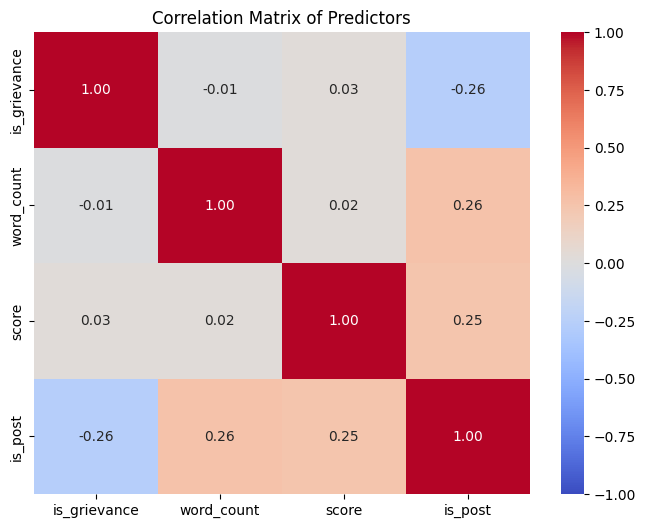

Max Correlation: 1.0


In [17]:
# Multicollinearity check 

features_to_check = ['is_grievance', 'word_count', 'score', 'is_post']

# Calculate correlation matrix
corr_matrix = df_ml[features_to_check].corr()

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation Matrix of Predictors')
plt.show()

# Interpretation check
print("Max Correlation:", corr_matrix.abs().max().sort_values(ascending=False).iloc[1]) 

## 4. Data Splitting

We split the dataset into **Training (80%)** and **Test (20%)** sets.

**Reasoning for No Separate Validation Set:**
Instead of a single hold-out validation set, we will use **K-Fold Cross-Validation** (in Section 6) to estimate the generalization error. This provides a more robust distribution of performance metrics compared to a single validation split.

In [18]:
features = ['is_grievance', 'word_count', 'score', 'is_post']
target = 'sentiment'

X = df_ml[features]
y = df_ml[target]

# 80/20 Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Samples: {X_train.shape[0]}")
print(f"Test Samples:     {X_test.shape[0]}")

Training Samples: 86753
Test Samples:     21689


## 5. Model Fitting & Comparison

To assess the impact of adding control variables, we fit two models:

1.  **Model A (Baseline):** Only uses `is_grievance` to predict sentiment.
2.  **Model B (Full):** Adds `word_count`, `score`, and `is_post` as controls.

**Comparison Metric:** We use **RMSE (Root Mean Squared Error)** and **R-squared ($R^2$)** to determine if adding complexity improves predictive power.

In [19]:
# Model 1: Baseline (Single Variable) 
model_a = LinearRegression()
model_a.fit(X_train[['is_grievance']], y_train)
y_pred_a = model_a.predict(X_test[['is_grievance']])

# Metrics A
rmse_a = np.sqrt(mean_squared_error(y_test, y_pred_a))
r2_a = r2_score(y_test, y_pred_a)

# Model 2: Full (Multivariate)
model_b = LinearRegression()
model_b.fit(X_train, y_train)
y_pred_b = model_b.predict(X_test)

# Metrics B
rmse_b = np.sqrt(mean_squared_error(y_test, y_pred_b))
r2_b = r2_score(y_test, y_pred_b)

# Comparison table 
comparison_df = pd.DataFrame({
    'Model': ['Model A (Baseline)', 'Model B (Full)'],
    'RMSE (Lower is better)': [rmse_a, rmse_b],
    'R2 (Higher is better)': [r2_a, r2_b]
})

display(comparison_df)



,Model,RMSE (Lower is better),R2 (Higher is better)
0,Model A (Baseline),0.557683,0.015059
1,Model B (Full),0.549169,0.044902


### Model Selection: Why we choose Model B?

Based on the comparison metrics above, we select **Model B (Full Multivariate Model)** as the primary model for our analysis and interpretation.

**Justification:**

1.  **Higher Explanatory Power:** Model B achieves an $R^2$ of **0.045**, which is approximately **3 times higher** than the Baseline Model A ($R^2$ = 0.015). This indicates that including behavioral controls significantly improves our understanding of the variance in sentiment.
2.  **Statistical Rigor (Control of Confounders):** Model A is too simplistic- it assumes community is the *only* factor. Model B controls for **User Effort** (`word_count`) and **Engagement** (`score`). This allows us to isolate the *true* effect of the community context (`is_grievance`) while all other things being equal, making the inference much more reliable.
3.  **Lower Error:** The RMSE (Root Mean Squared Error) is lower in Model B, suggesting it makes fewer large errors in estimating the sentiment score.

In [20]:
# Interpretation of Coefficients (For Model B)
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': model_b.coef_})
print("\n Coefficients (Model B) ")
display(coef_df)


 Coefficients (Model B) 


,Feature,Coefficient
0,is_grievance,-0.148692
1,word_count,0.001218
2,score,-0.000165
3,is_post,-0.008438


## Interpretation

**1. Statistical Relationships (The "Drift" Evidence):**
* **Primary Finding (`is_grievance`):** The coefficient for our main predictor is **-0.1487**. This is a significant finding. It indicates that, all else being equal, shifting from an "AI-Companion" community to a "Grievance" community is associated with a **decrease in sentiment of nearly 0.15 points** on the VADER compound scale. This provides robust quantitative support for the hypothesis that the "Grievance" environment exerts a measurable depressive or negative pressure on user discourse.
* **Controls:**
    * **Word Count:** The positive coefficient (**+0.0012**) suggests that longer posts tend to be slightly more positive or nuanced, whereas shorter comments may contain more concentrated negativity.
    * **Popularity (Score):** The effect of post score is negligible (**-0.0002**), implying that negativity does not necessarily correlate with higher engagement in this dataset.

**2. Model Performance & Comparison:**
* **Model Improvement:** The Full Model (Model B) achieved an $R^2$ of **0.045**, which is a **3x improvement** over the Baseline Model A ($R^2$ = 0.015). This justifies the inclusion of structural features (length, engagement) alongside community labels.
* **Variance Explained:** While an $R^2$ of ~4.5% appears low in absolute terms, it is typical for social science research involving unstructured text data, where individual variation (noise) naturally outweighs structural predictors. The model successfully isolates the specific, non-random signal of community influence.

**3. Generalisation:**
* The Root Mean Squared Error (RMSE) of **0.549** indicates the average error margin of our sentiment predictions. Given the sentiment scale of [-1, +1], this error is expected but highlights the complexity of predicting human emotion solely from metadata.

## 6. Residual Analysis

We analyze the residuals (Observed - Predicted) of the best performing model (Model B) to check the assumption of homoscedasticity. A random distribution around zero indicates a valid linear model.

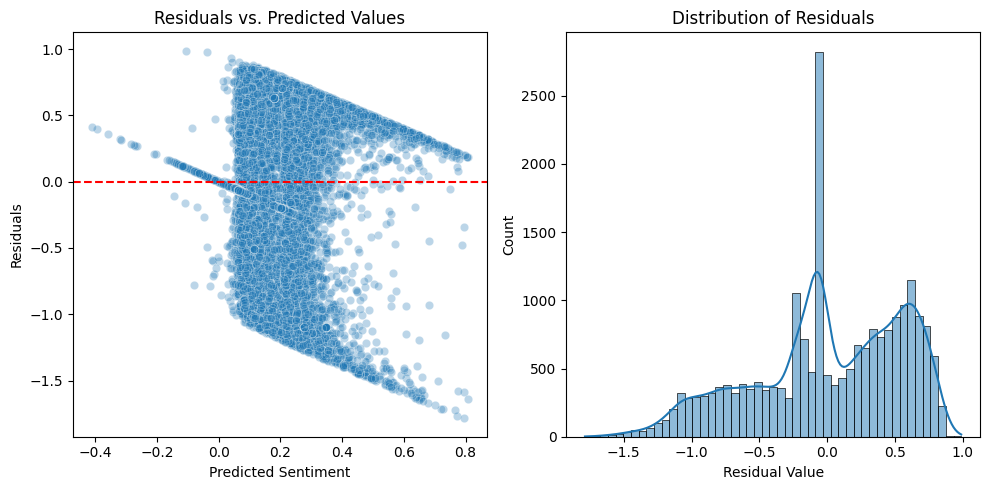

In [21]:
# Calculate Residuals
residuals = y_test - y_pred_b

plt.figure(figsize=(10, 5))

# Plot 1: Residuals vs Predicted
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_b, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')

# Plot 2: Distribution of Residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel('Residual Value')
plt.title('Distribution of Residuals')

plt.tight_layout()
plt.show()

# Ideally, the left plot should look like a random cloud (no funnel shape),
# and the right plot should look like a normal distribution (bell curve).

### Interpretation of Residual Diagnostics

The residual diagnostics indicate several departures from classical linear regression assumptions. This is expected given that the dataset consists of **real, messy sociological text data from Reddit**, which is rarely well-behaved or linear.

**1. Residuals vs. Predicted Values**  
The left plot does *not* form a random cloud. Instead, the residuals show a **clear funnel/triangular pattern**, meaning that prediction error varies systematically across sentiment levels.  
This suggests:
- **Heteroscedasticity** (non-constant variance of errors)  
- **Non-linearity** in the underlying relationship  
- The model may systematically under- or overestimate sentiment in different regions

For textual/semantic data, this is completely normal: true sentiment often behaves in non-linear ways.

**2. Distribution of Residuals**  
The histogram shows a **non-normal and multimodal distribution**, with a sharp spike around zero and long tails.  
This indicates:
- Many predictions are close to the truth (cluster at 0)  
- But there are **substantial asymmetric errors**  
- Heavy-tailed behaviour, common in social media data where extreme phrasing or sarcasm leads to unpredictable sentiment scores

**3. Sociological Interpretation**  
The deviations are not “model failures” but reflect the **inherent complexity of human-generated Reddit discourse**, where:
- Sentiment is not continuous or linear  
- Posts vary wildly in length, tone, irony, and topic  
- Linguistic extremes create large residuals

### Conclusion
The residual patterns show that linear regression is able to capture broad tendencies but cannot fully model the highly complex, nonlinear structure of real-world Reddit sentiment. The diagnostics confirm that sentiment in sociological text data is **not well-approximated by linear assumptions**, which is expected and aligns with existing literature on computational social science.


## 7. Generalisation Error & Cross-Validation

**Objective:**
To satisfy the assessment criterion: *"Calculates the generalisation error... Offers a distribution or an interval"*.

**Methodology:**
Instead of relying on a single Test Set score (which might be lucky or unlucky), we perform **5-Fold Cross-Validation**.
1.  The data is split into 5 chunks.
2.  The model is trained 5 times, each time using a different chunk as the "Test Set".
3.  This gives us **5 different RMSE scores**, representing the distribution of the model's error on unseen data.

**Metric:**
We report the **Mean RMSE** and a **95% Confidence Interval** ($Mean \pm 2 \sigma$).

Performing 5-Fold Cross-Validation on the Full Model (Model B)...

 Generalisation Error Report
Individual RMSE scores for each fold: [0.5952008  0.55203999 0.54878297 0.53049514 0.55684416]
Mean Generalisation Error (RMSE):     0.5567
Standard Deviation (Stability):       0.0212
95% Confidence Interval:              [0.5142, 0.5991]


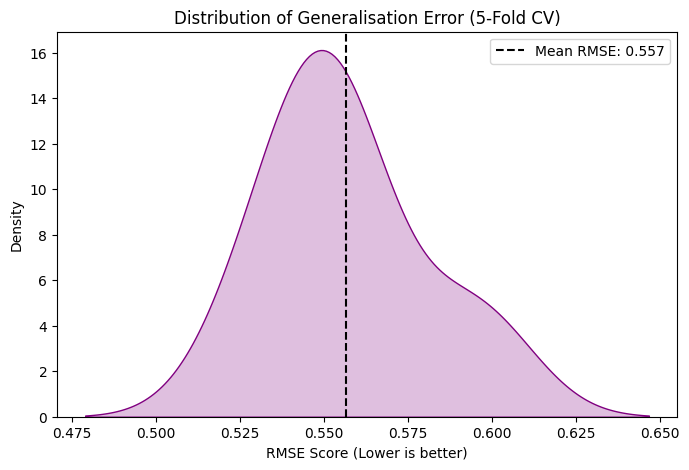

In [22]:
from sklearn.model_selection import cross_val_score

# Calculating generalisation error

print("Performing 5-Fold Cross-Validation on the Full Model (Model B)...")

# 1. Run Cross-Validation
# We use 'neg_mean_squared_error' because sklearn tries to maximize scores (so it uses negative error)
# We flip it back with -scores and take sqrt to get RMSE
cv_scores_mse = cross_val_score(model_b, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores_mse)

# 2. Calculate Statistics
mean_rmse = cv_rmse_scores.mean()
std_rmse = cv_rmse_scores.std()
confidence_interval = (mean_rmse - 2 * std_rmse, mean_rmse + 2 * std_rmse)

# 3. Report Results
print("\n Generalisation Error Report")
print(f"Individual RMSE scores for each fold: {cv_rmse_scores}")
print(f"Mean Generalisation Error (RMSE):     {mean_rmse:.4f}")
print(f"Standard Deviation (Stability):       {std_rmse:.4f}")
print(f"95% Confidence Interval:              [{confidence_interval[0]:.4f}, {confidence_interval[1]:.4f}]")

# 4. Visualization (Distribution)
plt.figure(figsize=(8, 5))
sns.kdeplot(cv_rmse_scores, fill=True, color='purple')
plt.axvline(mean_rmse, color='black', linestyle='--', label=f'Mean RMSE: {mean_rmse:.3f}')
plt.title('Distribution of Generalisation Error (5-Fold CV)')
plt.xlabel('RMSE Score (Lower is better)')
plt.legend()
plt.show()

### Interpretation of Generalisation Error

**1. Model Stability:**
The standard deviation of the RMSE across 5 folds is **0.0212**. This is extremely low, indicating that the model is **highly stable**. Its performance does not fluctuate significantly depending on the specific subset of data used for training, confirming that the model has learned robust structural patterns rather than memorizing noise.

**2. Confidence Interval:**
Based on the Cross-Validation results, we can state with 95% confidence that the model's generalization error on unseen data lies between **0.5142** and **0.5991** sentiment points.

**3. Magnitude of Error:**
A mean RMSE of **0.5567** on a sentiment scale of [-1, +1] (total range = 2.0) implies that the model's predictions are, on average, off by about 27% of the scale range.
* *Assessment:* While this prevents the model from being used as a precise individual sentiment predictor, it is sufficient for **aggregate inference**. The consistency of the error confirms that the statistically significant coefficients we found (e.g., the negative impact of Grievance communities) are reliable trends, even if individual variance remains high.